In this notebook we will generate the three different estimators analyzed in the paper on the benchmark _Laekaemia_ dataset. To get the samples from the desired distributions, since the model is non-conjugate, we will leverage **PyStan**. To see how to create the models in **PyStan** refer to the code in the module _logistic_model.py_. To run the notebook one has to have installed the **PyStan** library, the **psis** directory and the _Laekamia_ dataset in a proper location.

In [23]:
#import logistic_model as lm
from models import Logistic_Model as lm
import models
from scipy.special import logsumexp
import pystan     ## this is because it is the latest version of pystan, might need to run import pystan if you have older version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,"./../PSIS/py/")
import psis
from scipy.stats import laplace,bernoulli
import time
#import nest_asyncio


## Let us load the data, create the model, and then create the dictionary which we are going to pass to **PyStan**

In [24]:
data = pd.read_csv("./../Data/leukaemia.csv")
y = data["y"].values.astype(int)
X = data.loc[::,"ones":"ag"].values

n=X.shape[0]
k=X.shape[1]
prior_scale = np.sqrt(50/k)
data={"n":n, "k":k, "y":y.reshape(30), "X":X, "prior_scale":prior_scale}

µ=0
beta0=prior_scale
#model=lm.Model(µ,beta0) 
model = lm(y, X, μ, beta0)

## Samples from the full posterior

In [12]:
#nest_asyncio.apply()
iterations = 4000  ##number of iterations for each chain
n_chains = 1;  warmup = 500;
#model_post = lm.posterior()
model_post = model.str_post()
sm_posterior = pystan.StanModel(model_code=model_post)
#sm_posterior = stan.build(model_post, data=data)
fit_posterior = sm_posterior.sampling(data=data, iter=iterations, chains=n_chains, warmup=warmup, seed=101)
#fit_posterior = sm_posterior.sample(num_chains=n_chains, num_samples=iterations)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad2828a801282485dceba485ea500ee3 NOW.


## Samples from the mixture

In [14]:
#nest_asyncio.apply()
iterations = 4000  ##number of iterations for each chain
n_chains = 1;  warmup = 500;
#n_samples = n_chains*(iterations-warmup)
#model_mix = lm.mixture()
model_mix = model.str_mix()
sm_mix = pystan.StanModel(model_code=model_mix)
#sm_mix = stan.build(model_mix, data=data)
#fit_mix = sm_mix.sample(num_chains=n_chains, num_samples=iterations)
fit_mix = sm_mix.sampling(data=data, iter=iterations, chains=n_chains, warmup=warmup, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52302afb3c804f044fed2d640af46573 NOW.


## Estimators

In [16]:
### Posterior estimator
## Here we compute the estimator explicitly in its' different components
betas_posterior=fit_posterior['beta'].transpose()
n_samples = betas_posterior.shape[1]
w_posterior=np.zeros((X.shape[0], n_samples))
lppd_posterior = np.zeros((n_samples,n))


for i in range(n_samples):
    w_posterior[::, i]=(1/np.exp(np.dot(X,betas_posterior[::,i:i+1])*y.reshape((n,1)))+
    np.exp(np.dot(X,betas_posterior[::,i:i+1])-(np.dot(X,betas_posterior[::,i:i+1])*y.reshape((n,1))))).reshape(n)
    
denominator_post = w_posterior.cumsum(axis=1)
#aux_post=np.array([model.model_i(betas_posterior,y,X,j) for j in range(n)])
aux_post=np.array([model.model_i(betas_posterior, j) for j in range(n)])
for i in range(n):
    numerator_post = (aux_post[i, ::]*w_posterior[i,::]).cumsum()
    lppd_posterior[::, i] = np.log(numerator_post/denominator_post[i,::])

In [17]:
## Mixture estimator
## The different auxiliary variables below are to mantain the computations efficient
lppd_mixture = np.zeros((n_samples, n))
betas_mixture=fit_mix['beta'].transpose()

start=time.time()

#aux_mix=np.array([model.model_i(betas_mixture,y,X,j)**(-1) for j in range(n)]).transpose()
aux_mix=np.array([model.model_i(betas_mixture, j)**(-1) for j in range(n)]).transpose()
common_mix=aux_mix.sum(axis=1)
numerator_ew_cum=((common_mix)**(-1)).cumsum()
for i in range(n):
    denominator_mix = (aux_mix[::,i]*(common_mix)**(-1)).cumsum()
    lppd_mixture[::, i] = np.log(numerator_ew_cum/denominator_mix)

end=time.time()
print(end-start)

0.00706028938293457


In [18]:
## PSIS estiamtor
#l_lik_post = -1 * (np.array([-1*model.lmodel_i(betas_posterior,y,X,j) for j in range(n)])).transpose()
l_lik_post = -1 * (np.array([-1*model.lmodel_i(betas_posterior, j) for j in range(n)])).transpose()
loo, lppd_psis, k_psis=psis.psisloo(l_lik_post)

## Traceplots

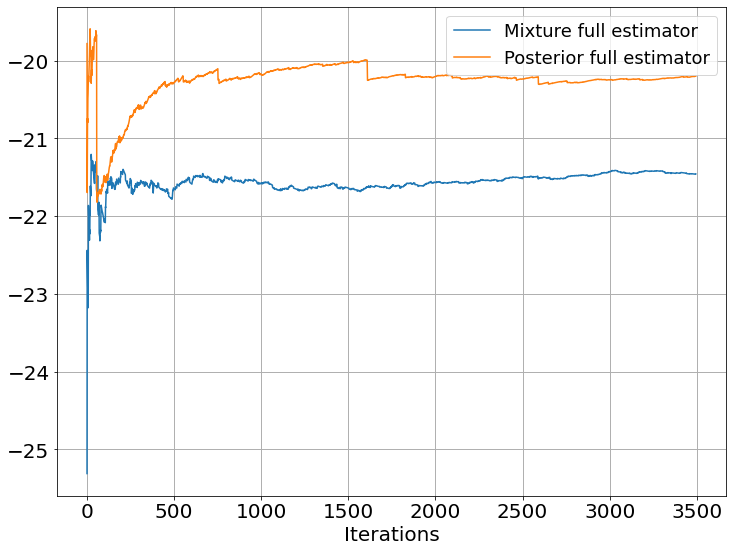

In [21]:
## We do not do the traceplots for the PSIS estimator as the module jut gives back the final value
mixture_estimator = lppd_mixture.sum(axis=1)
posterior_estimator = lppd_posterior.sum(axis=1)
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(mixture_estimator[5:], label="Mixture full estimator")
ax.plot(posterior_estimator[5:], label="Posterior full estimator")
plt.legend(fontsize=18)
ax.yaxis.set_tick_params(labelsize=20, rotation=0)
ax.xaxis.set_tick_params(labelsize=20, rotation=0)
ax.set_xlabel("Iterations", size=20)
plt.grid(linestyle='-', linewidth=1)

The above code was used because it allow to get the above traceplot. If one is just interested in the final an estimator, a much more efficient, and more importantly numerically stable, way would be the following. The code behind can be inspected at in the library __models.py__.

In [22]:
is_estimator = models.Is_estimators(model)
lppd_mixture = is_estimator.mixture(betas_mixture)
lppd_posterior = is_estimator.posterior(betas_posterior)
lppd_psis = is_estimator.PSIS(betas_posterior)